# Main training notebook

## Imports

In [1]:
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.models import resnet34, ResNet34_Weights

from torchvision.ops import FeaturePyramidNetwork

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset

from nilearn import datasets
from nilearn import plotting

from tqdm import tqdm

import numpy as np

import os

import matplotlib.pyplot as plt

from scipy.stats import pearsonr as corr

from utils.dataset import Dataset
from utils.model import RegressionHead

## Hyperparameters

In [3]:
EPOCHS = 200
lr = 0.0001
batch_size = 64
l2 = 0.0001

## Load dataset

Loading dataset sample names...
Training images: 9841
Test images: 159

LH training fMRI data shape:
(9841, 19004)
(Training stimulus images × LH vertices)
train-0001_nsd-00013.png
0


ValueError: Sum of input lengths does not equal the length of the input dataset!

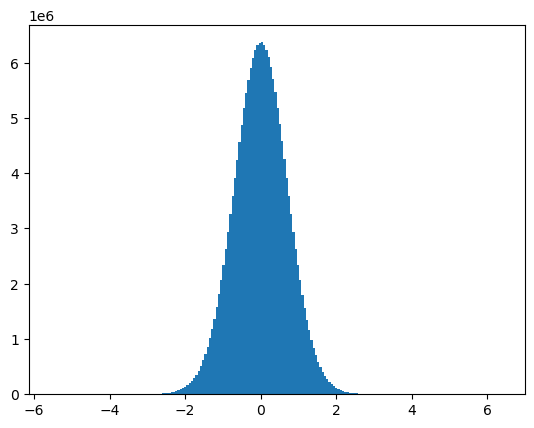

In [6]:
# loading dataset + creating train test split for verifying performance
dataset = Dataset("../../data/subj01")

output = next(iter(dataset))

train_set, val_set = torch.utils.data.random_split(dataset, [8200, 579])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)

## Feature extractor + trainable regression head instantiation

In [7]:
# loading pretrained model
device = torch.device("cuda")

model = resnet34(weights=ResNet34_Weights.DEFAULT)

layer_names = []

for name, layer in model.named_modules():
    if isinstance(layer, nn.Conv2d):
        layer_names += [name]

print(layer_names)

feature_extractor = create_feature_extractor(model, 
        return_nodes=["layer3.5.conv2"]).to(device)

feature_extractor.eval()

# instantiating trainable head
head = RegressionHead(1000).to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Instantiating loss function + optimizer

In [5]:
mse_weight = 1

criterion = nn.MSELoss() # loss
# optimizer = torch.optim.Adam(list(head.parameters()) + list(fpn.parameters()) + list(feature_extractor.parameters()), lr=lr, weight_decay=l2) # optimizer
optimizer = torch.optim.Adam(list(head.parameters()) + list(fpn.parameters()), lr=lr, weight_decay=l2) # optimizer

## Main training loop

In [6]:
train_loss = 0
val_loss = 0
count = 0

all_train_loss_vals = []
all_val_loss_vals = []

for epoch in range(EPOCHS):

    print("\nEpoch " + str(epoch))

    # setting to train mode for gradient calculations
    head.train()

    for i, (inputs, targets) in tqdm(enumerate(train_loader), total=int(8500/batch_size)+1):
        inputs = inputs.to(device)
        # targets = targets.to(device)[:, np.where(challenge_roi)[0]] # selecting proper vertices based on ROI
        targets = targets.to(device)

        optimizer.zero_grad()

        with torch.no_grad():
            # feature extractor backbone
            outputs = feature_extractor(inputs)
        
        # trainable FPN
        outputs = fpn(outputs)

        # trainable head
        outputs = head(outputs)

        loss = criterion(outputs, targets[:,:1000])
        loss.backward()

        del inputs
        del targets
        del outputs

        count += 1

        train_loss = train_loss + loss.item()

        optimizer.step()

        torch.cuda.empty_cache() # frees up memory for val

    all_train_loss_vals += [(train_loss)/count]
    
    print("Train loss: " + str(train_loss/count))

    count = 0

    head.eval()
    
    with torch.no_grad():
        for i, (inputs, targets) in tqdm(enumerate(val_loader), total=int(582/batch_size)+1):
            inputs = inputs.to(device)
            #targets = targets.to(device)[:, np.where(challenge_roi)[0]] # selecting proper vertices based on ROI
            targets = targets.to(device)
            
            # feature extractor backbone
            outputs = feature_extractor(inputs)
            outputs = fpn(outputs)

            # trainable head
            outputs = head(outputs)

            loss = criterion(outputs, targets[:,:1000])

            del inputs
            del targets
            del outputs

            count += 1

            val_loss = val_loss + loss.item()

            torch.cuda.empty_cache() # frees up memory for val

    all_val_loss_vals += [(val_loss)/count]
    
    print("Val loss: " + str(val_loss/count))

    train_loss = 0
    val_loss = 0
    
    count = 0


Epoch 0


  6%|▌         | 8/133 [00:11<02:57,  1.42s/it]


KeyboardInterrupt: 

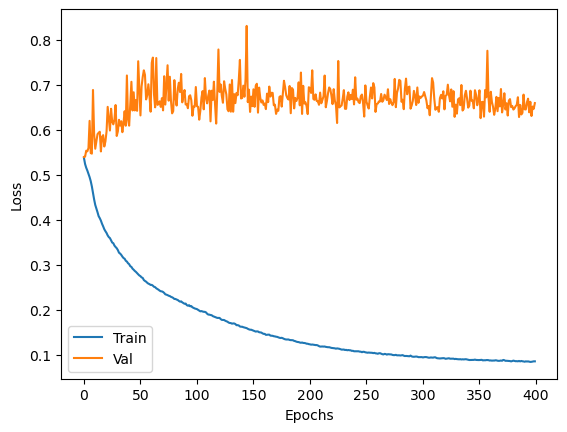

In [8]:
plt.plot([i for i in range(EPOCHS)], all_train_loss_vals, label="Train")
plt.plot([i for i in range(EPOCHS)], all_val_loss_vals, label="Val")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig("./loss_graphs/200_epochs_subj4_left5.png")

## Saving trained model

In [9]:
torch.save(head.state_dict(), "saved_models/200_epochs_subj04_left_5")

## Output distribution visualization

Output dims: torch.Size([19004])
Target dims: torch.Size([19004])
Output mean: tensor(-0.1719, device='cuda:0')
Target mean: tensor(-0.1038)
Output standard deviation: tensor(0.5581, device='cuda:0')
Target standard deviation: tensor(0.5586)
Loss: tensor(0.0945)


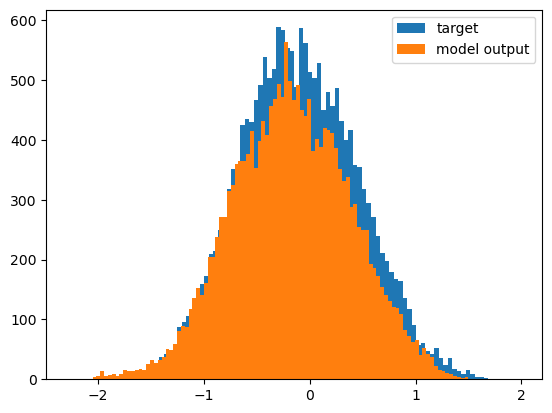

In [16]:
sample = next(iter(train_loader))

feature_extractor.to(device)
fpn.to(device)
head.to(device)

visualize_output = feature_extractor(sample[0].to(device))
visualize_output = fpn(visualize_output)
visualize_output = head(visualize_output).detach()

print("Output dims: " + str(visualize_output[0].size()))
print("Target dims: " + str(sample[1][0].size()))

print("Output mean: " + str(torch.mean(visualize_output[0])))
print("Target mean: " + str(torch.mean(sample[1][0])))

print("Output standard deviation: " + str(torch.std(visualize_output[0])))
print("Target standard deviation: " + str(torch.std(sample[1][0])))

loss = criterion(visualize_output[0].to("cpu"), sample[1][0].to("cpu")[:1000])

print("Loss: " + str(loss))

plt.hist(sample[1][0].numpy()[:1000], bins=100, label="target")
plt.hist(visualize_output[0].to("cpu").numpy(), bins=100, label="model output")
plt.legend(loc="upper right")
plt.savefig("histograms/" + "200_epochs_subj4_left5" + ".jpg")

## Submission correlation score test

In [17]:
feature_extractor.to(device)
fpn.to(device)
head.to(device)

feature_extractor.eval()
head.eval()

n_left_vertices = 19004

left_outputs = torch.zeros(841, n_left_vertices).to(device)

final_left_targets = torch.zeros(841, n_left_vertices).to(device)

with torch.no_grad():
    for i, (inputs, targets) in tqdm(enumerate(train_loader), total=int(300/batch_size)+1):
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        outputs = feature_extractor(inputs)
        outputs = fpn(outputs)
        # trainable head
        outputs = head(outputs)

        final_left_targets[i*batch_size:i*batch_size+batch_size] = targets
        left_outputs[i*batch_size:i*batch_size+batch_size] = outputs
        
        del inputs
        del targets
        del outputs

        torch.cuda.empty_cache() # frees up memory

        if i == 8:
            break

lh_correlation = torch.zeros(final_left_targets.shape[1])
for v in tqdm(range(final_left_targets.shape[1])):
    lh_correlation[v] = torch.tensor(corr(left_outputs[:,v].detach().cpu(), final_left_targets[:,v].detach().cpu())[0]) ** 2

score = torch.median(lh_correlation) * 100

print(score)

8it [00:09,  1.13s/it]                       
100%|██████████| 19004/19004 [00:05<00:00, 3619.16it/s]

tensor(3.9134)


In [ ]:
feature_extractor.to(device)
fpn.to(device)
head.to(device)

feature_extractor.eval()
head.eval()

n_left_vertices = 19004

left_outputs = torch.zeros(841, n_left_vertices).to(device)

final_left_targets = torch.zeros(841, n_left_vertices).to(device)

with torch.no_grad():
    for i, (inputs, targets) in tqdm(enumerate(val_loader), total=int(300/batch_size)+1):
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        outputs = feature_extractor(inputs)
        outputs = fpn(outputs)
        # trainable head
        outputs = head(outputs)

        final_left_targets[i*batch_size:i*batch_size+batch_size] = targets
        left_outputs[i*batch_size:i*batch_size+batch_size] = outputs
        
        del inputs
        del targets
        del outputs

        torch.cuda.empty_cache() # frees up memory

        if i == 8:
            break

lh_correlation = torch.zeros(final_left_targets.shape[1])
for v in tqdm(range(final_left_targets.shape[1])):
    lh_correlation[v] = torch.tensor(corr(left_outputs[:,v].detach().cpu(), final_left_targets[:,v].detach().cpu())[0]) ** 2

score = torch.median(lh_correlation) * 100

print(score)